In [100]:
import pandas as pd
import seaborn as sns
#import pandas_profiling
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import sklearn.feature_extraction.text as text
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import warnings
!pip install contractions
import contractions
from collections import Counter
!pip install wordcloud
from wordcloud import WordCloud
from sklearn. preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import nltk
nltk.download('stopwords')
import numpy as np
warnings.filterwarnings('ignore')
import gensim
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\16199\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\16199\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [101]:
data = pd.read_json('data.json',lines = True)

In [157]:
data['category'].unique().shape

(42,)

In [103]:
new_mappings = {tuple(['U.S. NEWS', 'WORLD NEWS',  'GOOD NEWS' , 'THE WORLDPOST','WORLDPOST']): 'NEWS',
                  tuple(['CULTURE & ARTS', 'TRAVEL','ARTS & CULTURE','ARTS']): 'TRAVEL AND ARTS',
                                                  tuple(['WELLNESS','STYLE & BEAUTY','HOME & LIVING','HEALTHY LIVING','STYLE']): 'LIFESTYLE',
                                                 tuple(['TASTE','FOOD & DRINK']): 'FOOD',
                                                  tuple(['QUEER VOICES', 'BLACK VOICES','LATINO VOICES','WOMEN']): 'DIVERSITY',
                                                  tuple(['COMEDY','SPORTS','ENTERTAINMENT','WEIRD NEWS']): 'ENTERTAINMENT',
                                                  tuple(['BUSINESS','MONEY']): 'BUSINESS',
                                                  tuple(['COLLEGE','PARENTING','EDUCATION','PARENTS']): 'PARENTING AND EDUCATION',
                                                  tuple(['CRIME','FIFTY','IMPACT','WEDDINGS','DIVORCE','RELIGION']): 'MISCELLANEOUS',
                                                tuple(['POLITICS','MEDIA']): 'POLITICS',
                                                 tuple(['ENVIRONMENT','GREEN']): 'ENVIRONMENT',
                                                 tuple(['TECH','SCIENCE']): 'TECHNOLOGY'
                }

In [104]:
new_mapping_dict = {}
for key, value in new_mappings.items():
    for one_key in key:
        new_mapping_dict[one_key] = value

In [105]:
data['new_category'] = data['category'].replace(new_mapping_dict)
data.loc[:,['category','new_category']]

,category,new_category
0,U.S. NEWS,NEWS
1,U.S. NEWS,NEWS
2,COMEDY,ENTERTAINMENT
3,PARENTING,PARENTING AND EDUCATION
4,U.S. NEWS,NEWS
...,...,...
209522,TECH,TECHNOLOGY
209523,SPORTS,ENTERTAINMENT
209524,SPORTS,ENTERTAINMENT
209525,SPORTS,ENTERTAINMENT


In [106]:
data.drop_duplicates(inplace = True)

In [107]:
data.drop_duplicates(subset=['headline', 'short_description'], inplace = True)

In [108]:
data.shape

(209038, 7)

In [109]:
data.isnull().values.any()

False

Number of unique categories:  12


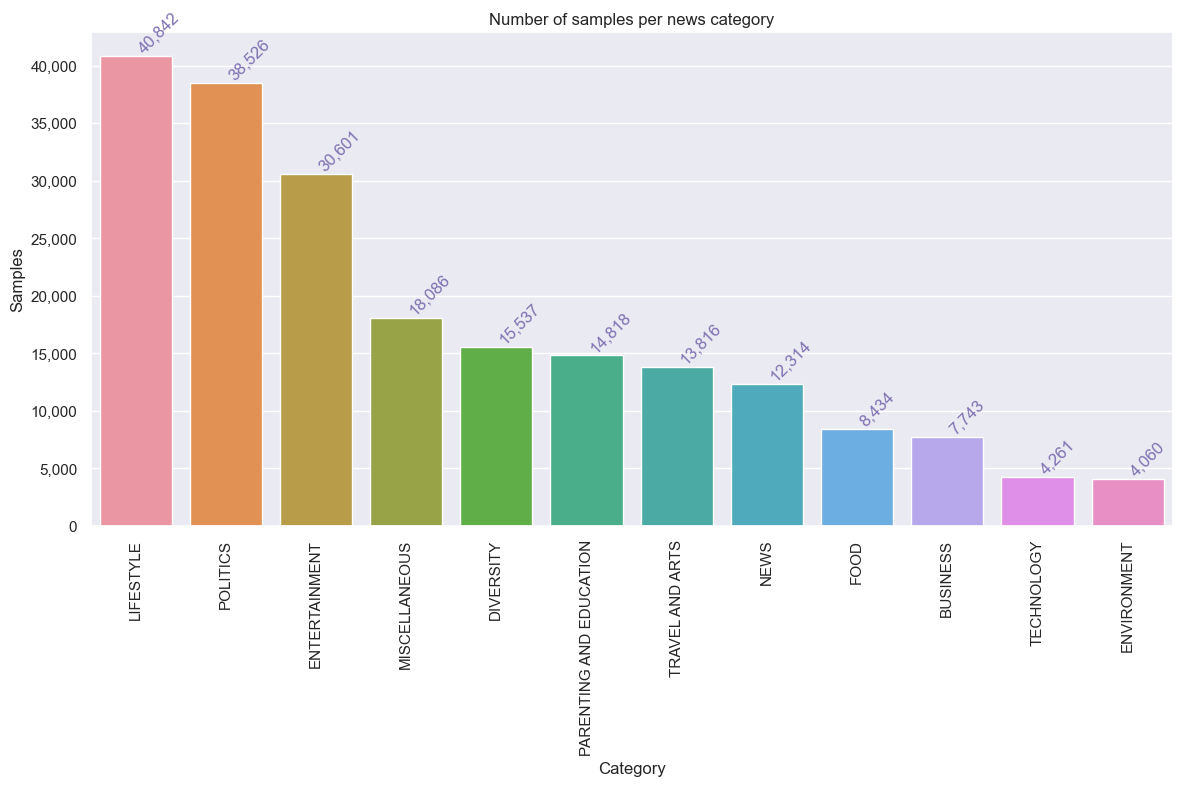

In [110]:
print('Number of unique categories: ',data.new_category.nunique())
pd_df= data.new_category.value_counts().to_frame().reset_index()
pd_df.columns = ['Category', 'Count']
#pd_df = pd_df.sort_values(['Count']).reset_index(drop=True)
plt.figure(figsize=(12,8))
plt.title("Number of samples per news category")
# plot barh chart with index as x values
ax = sns.barplot(pd_df.index, pd_df.Count)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set(xlabel="Category", ylabel='Samples')
ax.set_xticklabels(pd_df.Category)
for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(pd_df["Count"].iteritems()):        
    ax.text(i ,v[1], "{:,}".format(v[1]), color='m', va ='bottom', rotation=45)
plt.tight_layout()
plt.show()

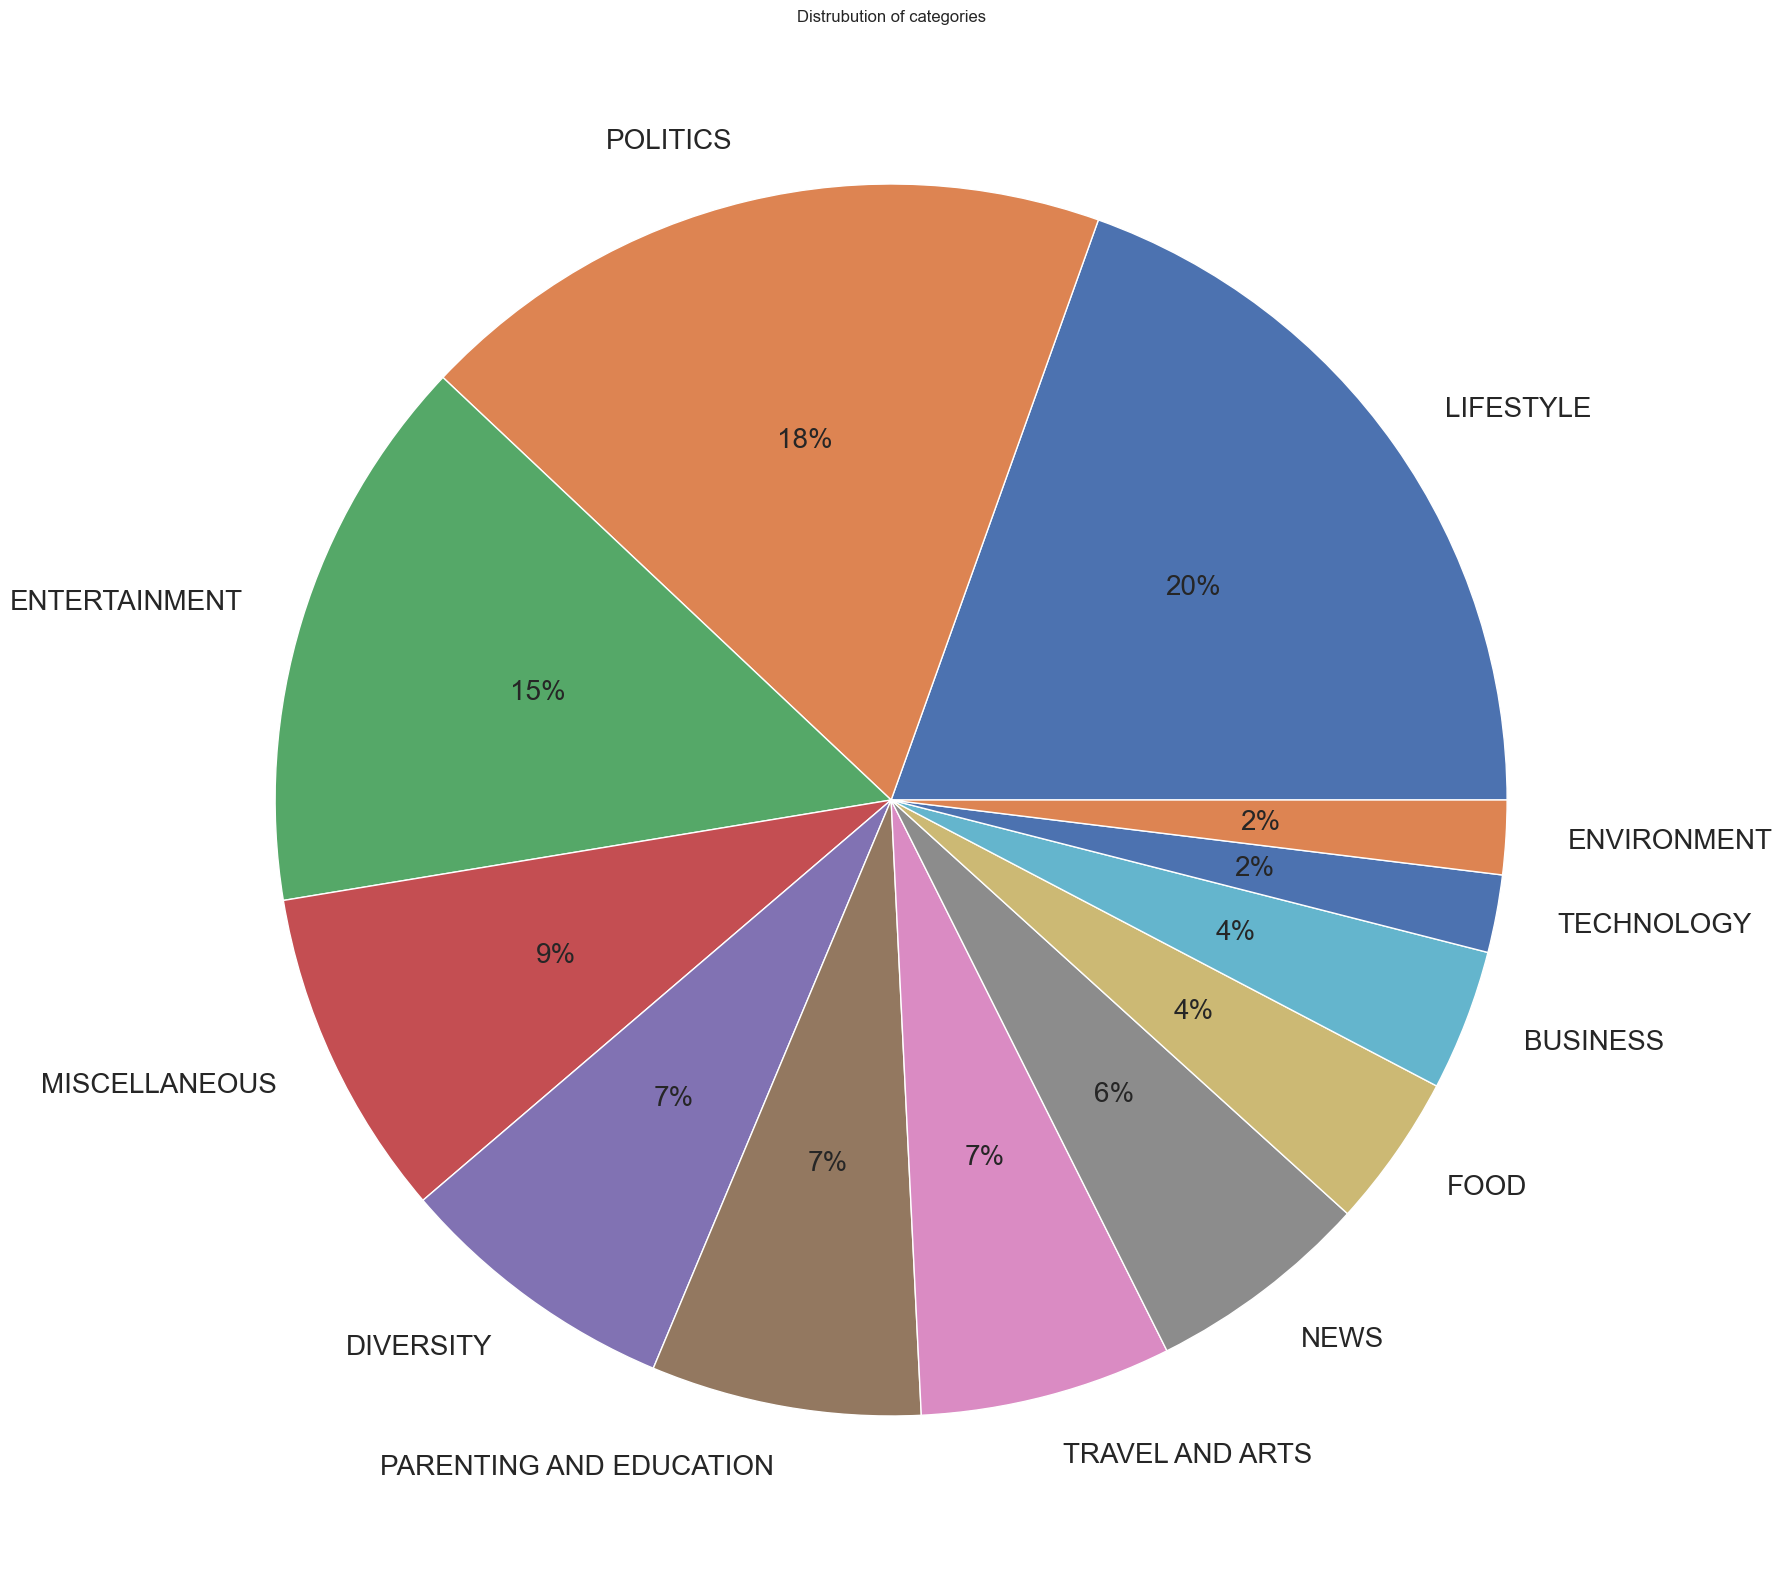

In [111]:
plt.figure(figsize = (30,20))
plt.title("Distrubution of categories")
plt.pie(pd_df.Count, labels = pd_df.Category, autopct='%.0f%%',textprops={'fontsize': 20})
plt.show()

Number of Authors:  12
             Author  Count
0        David Moye   1067
1     Andy McDonald   1100
2    Curtis M. Wong   1146
3   Carly Ledbetter   1169
4      Cole Delbyck   1266
5  Reuters, Reuters   1563
6    Mary Papenfuss   1566
7          Ed Mazza   1590
8        Ron Dicker   2219
9         Lee Moran   2954


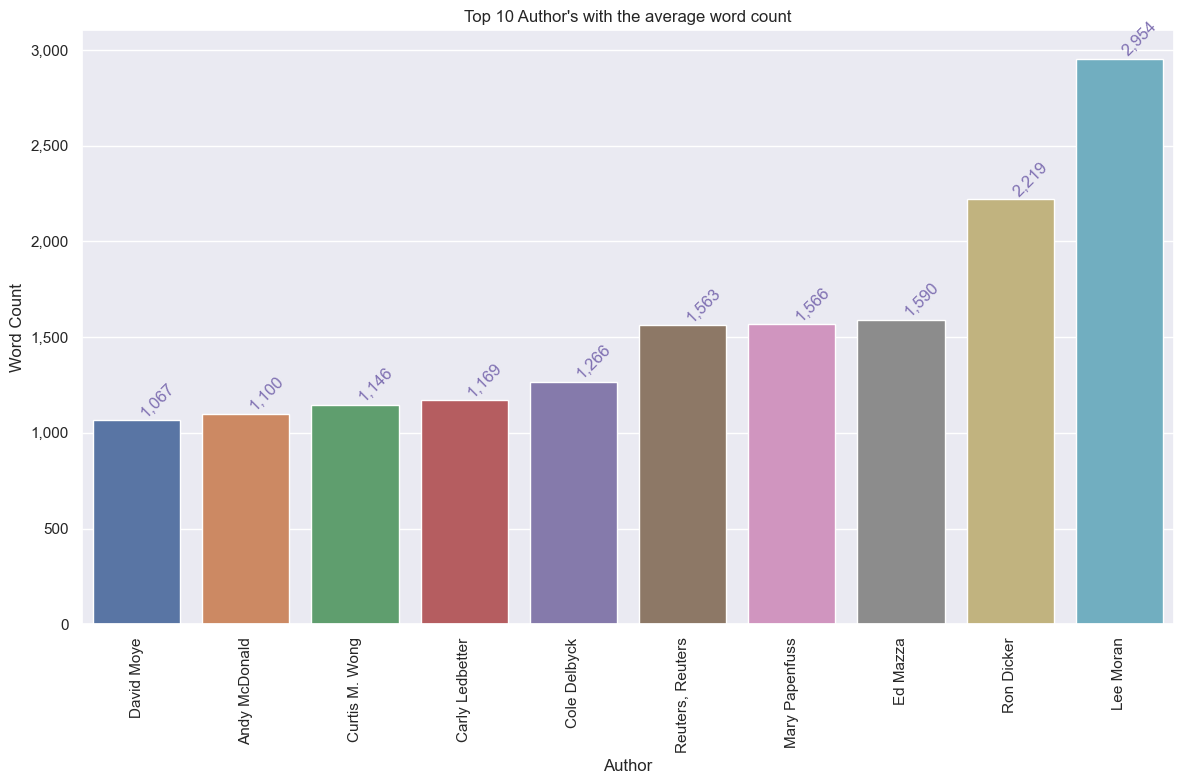

In [112]:
print('Number of Authors: ',data.new_category.nunique())
author_count = data.authors.value_counts().to_frame().reset_index()
author_count.columns = ['Author', 'Count']
author_count = author_count.drop(index=0)
author_count = author_count.loc[1:10, :]
author_count.head(10)
author_count = author_count.sort_values(['Count']).reset_index(drop=True)
print (author_count)
plt.figure(figsize=(12,8))
plt.title("Top 10 Author's with the average word count")
ax = sns.barplot(author_count.index, author_count.Count)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set(xlabel="Author", ylabel='Word Count')
ax.set_xticklabels(author_count.Author)
for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(author_count["Count"].iteritems()):        
    ax.text(i ,v[1], "{:,}".format(v[1]), color='m', va ='bottom', rotation=45)
plt.tight_layout()
plt.show()


In [113]:
def get_word_counts(line):
    return len(str(line).split())


In [114]:
df = data
df.head()

,link,headline,category,short_description,authors,date,new_category
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,NEWS
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,NEWS
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,ENTERTAINMENT
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,PARENTING AND EDUCATION
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,NEWS


In [115]:
def get_word_counts(line):
    return len(str(line).split())

In [116]:
df['all_words'] = df['headline']+" "+df['short_description']

In [117]:
df['all_words'][0]

'Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.'

In [118]:
#Getting the total no of word count in headlines
df['Word Count in Headlines'] = df['headline'].apply(get_word_counts)
df['Word Count in Headlines'] 

0         11
1         13
2         13
3          9
4         11
          ..
209522     8
209523    10
209524    16
209525     8
209526     9
Name: Word Count in Headlines, Length: 209038, dtype: int64

In [119]:
#Getting the total no of word count in short_description
df['Word Count in Short Description'] = df['short_description'].apply(get_word_counts)
df['Word Count in Short Description']

0         29
1         28
2         12
3         25
4         25
          ..
209522    18
209523    20
209524    24
209525    20
209526    19
Name: Word Count in Short Description, Length: 209038, dtype: int64

In [120]:
#Getting the total no of word count of headlines and short description 
df['Total_Word_Count'] = df['all_words'].apply(get_word_counts)
df['Total_Word_Count'] 

0         40
1         41
2         25
3         34
4         36
          ..
209522    26
209523    30
209524    40
209525    28
209526    28
Name: Total_Word_Count, Length: 209038, dtype: int64

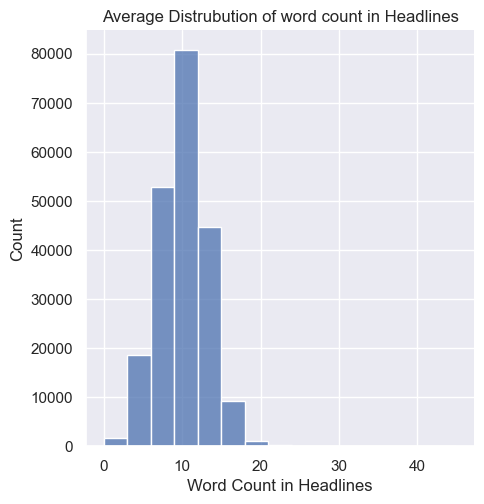

In [121]:
# Plotting Headline word count
sns.set(font_scale=1)

sns.displot(df, x="Word Count in Headlines", binwidth=3).set(
    title="Average Distrubution of word count in Headlines")


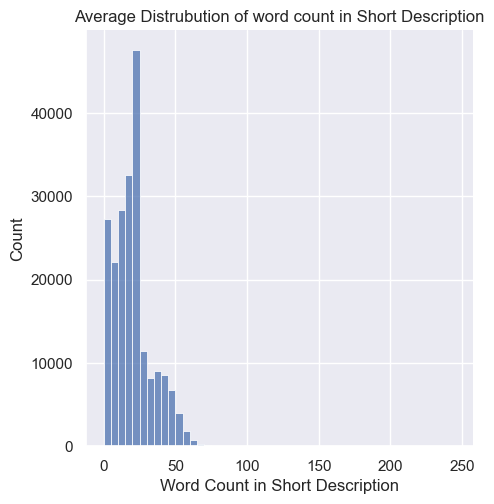

In [122]:
# Plotting Short description 
sns.set(font_scale=1)
sns.displot(df, x="Word Count in Short Description", binwidth=5).set(
    title="Average Distrubution of word count in Short Description")

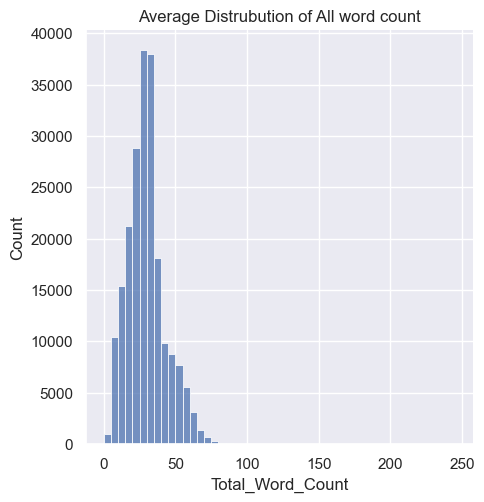

In [123]:
#Plooting all word count
sns.set(font_scale=1)
sns.displot(df, x="Total_Word_Count", binwidth=5).set(title="Average Distrubution of All word count")

In [124]:
# Getting the average of all word count by category
avg_word_length_by_category = df.loc[:,['new_category','Total_Word_Count']].groupby('new_category')\
.mean().reset_index().sort_values(['Total_Word_Count'], ascending= False)
avg_word_length_by_category

,new_category,Total_Word_Count
8,PARENTING AND EDUCATION,35.434067
5,LIFESTYLE,33.509451
11,TRAVEL AND ARTS,33.163796
0,BUSINESS,32.481725
6,MISCELLANEOUS,32.312230
3,ENVIRONMENT,30.295074
1,DIVERSITY,28.814121
10,TECHNOLOGY,26.732222
7,NEWS,26.674923
9,POLITICS,26.117739


In [125]:
#Top 10 of the average word count by cateogry
avg_word_length_by_category_top10 = avg_word_length_by_category.head(10)
avg_word_length_by_category_top10['Total_Word_Count']=avg_word_length_by_category_top10['Total_Word_Count'].apply(np.int64)
avg_word_length_by_category_top10

,new_category,Total_Word_Count
8,PARENTING AND EDUCATION,35
5,LIFESTYLE,33
11,TRAVEL AND ARTS,33
0,BUSINESS,32
6,MISCELLANEOUS,32
3,ENVIRONMENT,30
1,DIVERSITY,28
10,TECHNOLOGY,26
7,NEWS,26
9,POLITICS,26


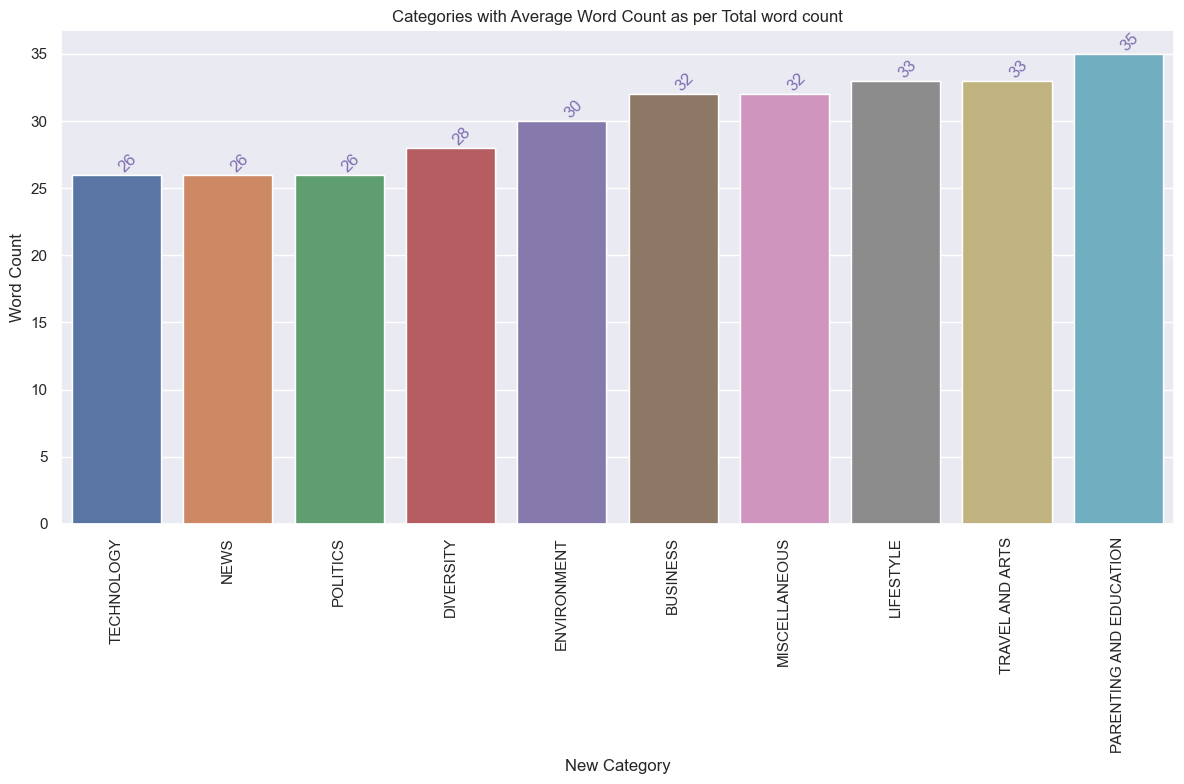

In [126]:

#plt.xticks(rotation=60,fontsize = 10)
author_count.columns = ['new_category', 'Total_Word_Count']
avg_word_length_by_category_top10 = avg_word_length_by_category_top10.sort_values(['Total_Word_Count']).reset_index(drop=True)
plt.figure(figsize=(12,8))
plt.title("Categories with Average Word Count as per Total word count")
ax = sns.barplot(avg_word_length_by_category_top10.index, avg_word_length_by_category_top10.Total_Word_Count)
sns.barplot(data=avg_word_length_by_category_top10, x="new_category", y="Total_Word_Count")
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set(xlabel="New Category", ylabel='Word Count')
ax.set_xticklabels(avg_word_length_by_category_top10.new_category)
for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(avg_word_length_by_category_top10["Total_Word_Count"].iteritems()):        
    ax.text(i ,v[1], "{:,}".format(v[1]), color='m', va ='bottom', rotation=45)
plt.tight_layout()
plt.show()


In [127]:
#data Cleaning / preprocessing

In [128]:
def expand_contractions(combined_words):
    expanded_words = []   
    for word in combined_words.split():
        expanded_words.append(contractions.fix(word))  
    expanded_text = ' '.join(expanded_words)
    return expanded_text

In [129]:
stop_words = set(stopwords.words('english'))

In [130]:
def remove_stop_words(x):
    lst = [i for i in x.split() if not i in stop_words]
    data = ' '.join(lst)
    return data

In [131]:
def clean_data(data):
    data = str(data)
    data = data.lower()
    data = expand_contractions(data)
    data = re.sub('@[A-Za-z0-9_]+',' ', data)
    data = re.sub('#[A-Za-z0-9_]+',' ', data)
    data = re.sub('(http\S+)', ' ', data)
    data = re.sub('www.\S+', ' ', data)
    data = re.sub('[()!?]', ' ', data)
    data = re.sub('\[.*?\]',' ', data)
    data = re.sub('[^a-z0-9]',' ', data)
    data = re.sub(' +',' ', data)
    data = remove_stop_words(data)
    return data

In [132]:
clean_df = df.loc[:,['all_words','new_category']]

In [133]:
clean_df['clean_all_words'] = clean_df['all_words'].apply(clean_data)

In [134]:
clean_df

,all_words,new_category,clean_all_words
0,Over 4 Million Americans Roll Up Sleeves For O...,NEWS,4 million americans roll sleeves omicron targe...
1,"American Airlines Flyer Charged, Banned For Li...",NEWS,american airlines flyer charged banned life pu...
2,23 Of The Funniest Tweets About Cats And Dogs ...,ENTERTAINMENT,23 funniest tweets cats dogs week sept 17 23 d...
3,The Funniest Tweets From Parents This Week (Se...,PARENTING AND EDUCATION,funniest tweets parents week sept 17 23 accide...
4,Woman Who Called Cops On Black Bird-Watcher Lo...,NEWS,woman called cops black bird watcher loses law...
...,...,...,...
209522,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECHNOLOGY,rim ceo thorsten heins significant plans black...
209523,Maria Sharapova Stunned By Victoria Azarenka I...,ENTERTAINMENT,maria sharapova stunned victoria azarenka aust...
209524,"Giants Over Patriots, Jets Over Colts Among M...",ENTERTAINMENT,giants patriots jets colts among improbable su...
209525,Aldon Smith Arrested: 49ers Linebacker Busted ...,ENTERTAINMENT,aldon smith arrested 49ers linebacker busted d...


In [135]:
clean_df.loc[:,['all_words','clean_all_words']]

,all_words,clean_all_words
0,Over 4 Million Americans Roll Up Sleeves For O...,4 million americans roll sleeves omicron targe...
1,"American Airlines Flyer Charged, Banned For Li...",american airlines flyer charged banned life pu...
2,23 Of The Funniest Tweets About Cats And Dogs ...,23 funniest tweets cats dogs week sept 17 23 d...
3,The Funniest Tweets From Parents This Week (Se...,funniest tweets parents week sept 17 23 accide...
4,Woman Who Called Cops On Black Bird-Watcher Lo...,woman called cops black bird watcher loses law...
...,...,...
209522,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,rim ceo thorsten heins significant plans black...
209523,Maria Sharapova Stunned By Victoria Azarenka I...,maria sharapova stunned victoria azarenka aust...
209524,"Giants Over Patriots, Jets Over Colts Among M...",giants patriots jets colts among improbable su...
209525,Aldon Smith Arrested: 49ers Linebacker Busted ...,aldon smith arrested 49ers linebacker busted d...


In [136]:
clean_df

,all_words,new_category,clean_all_words
0,Over 4 Million Americans Roll Up Sleeves For O...,NEWS,4 million americans roll sleeves omicron targe...
1,"American Airlines Flyer Charged, Banned For Li...",NEWS,american airlines flyer charged banned life pu...
2,23 Of The Funniest Tweets About Cats And Dogs ...,ENTERTAINMENT,23 funniest tweets cats dogs week sept 17 23 d...
3,The Funniest Tweets From Parents This Week (Se...,PARENTING AND EDUCATION,funniest tweets parents week sept 17 23 accide...
4,Woman Who Called Cops On Black Bird-Watcher Lo...,NEWS,woman called cops black bird watcher loses law...
...,...,...,...
209522,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECHNOLOGY,rim ceo thorsten heins significant plans black...
209523,Maria Sharapova Stunned By Victoria Azarenka I...,ENTERTAINMENT,maria sharapova stunned victoria azarenka aust...
209524,"Giants Over Patriots, Jets Over Colts Among M...",ENTERTAINMENT,giants patriots jets colts among improbable su...
209525,Aldon Smith Arrested: 49ers Linebacker Busted ...,ENTERTAINMENT,aldon smith arrested 49ers linebacker busted d...


In [137]:
X = clean_df['clean_all_words']
label = LabelEncoder()
Y = label.fit_transform(clean_df['new_category'])

In [138]:
text_all_words = " ".join(clean_all_words for clean_all_words in clean_df.clean_all_words)

In [139]:

word_cloud_all_words = WordCloud(collocations = False, background_color = 'black',
                        width = 2048, height = 1080).generate(text_all_words)
# saving the image
word_cloud_all_words.to_file('got.png')

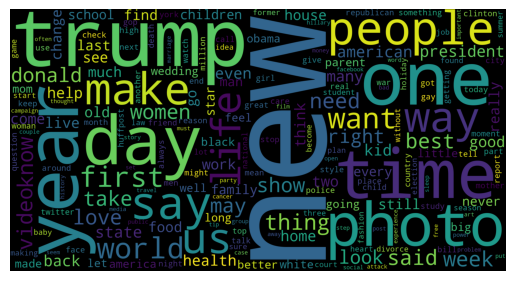

In [140]:
plt.imshow(word_cloud_all_words)
plt.axis("off")
plt.show()

In [141]:
# Word Cloud for politics
clean_politics=clean_df[clean_df["new_category"] == "POLITICS"]

text_politics = " ".join(clean_all_words for clean_all_words in clean_politics.clean_all_words)
word_cloud_politics = WordCloud(collocations = False, background_color = 'black',
                        width = 2048, height = 1080).generate(text_politics)
# saving the image
word_cloud_politics.to_file('Politics_wordCloud.png')

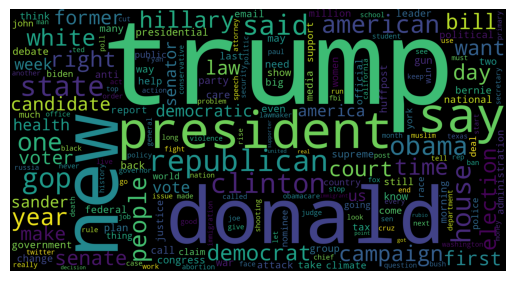

In [142]:
plt.imshow(word_cloud_politics)
plt.axis("off")
plt.show()

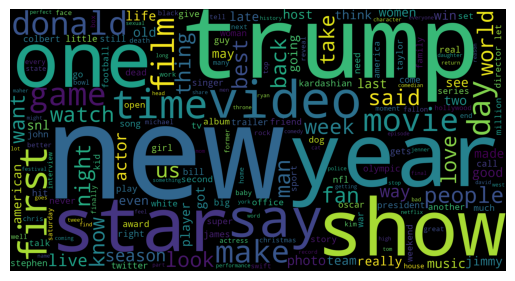

In [143]:
clean_entertainment=clean_df[clean_df["new_category"] == "ENTERTAINMENT"]
text_entertainment = " ".join(clean_all_words for clean_all_words in clean_entertainment.clean_all_words)
word_cloud_entertainment = WordCloud(collocations = False, background_color = 'black',
                        width = 2048, height = 1080).generate(text_entertainment)
# saving the image
word_cloud_entertainment.to_file('Entertainment_wordCloud.png')
plt.imshow(word_cloud_entertainment)
plt.axis("off")
plt.show()

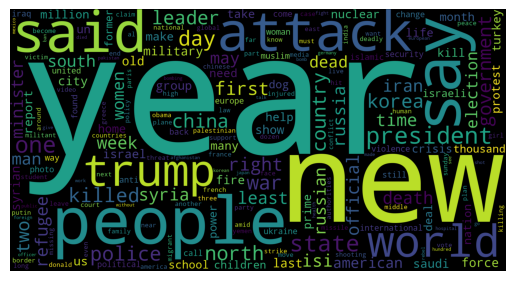

In [144]:
clean_news=clean_df[clean_df["new_category"] == "NEWS"]
text_news = " ".join(clean_all_words for clean_all_words in clean_news.clean_all_words)
word_cloud_news = WordCloud(collocations = False, background_color = 'black',
                        width = 2048, height = 1080).generate(text_news)
# saving the image
word_cloud_news.to_file('News_wordCloud.png')
plt.imshow(word_cloud_news)
plt.axis("off")
plt.show()

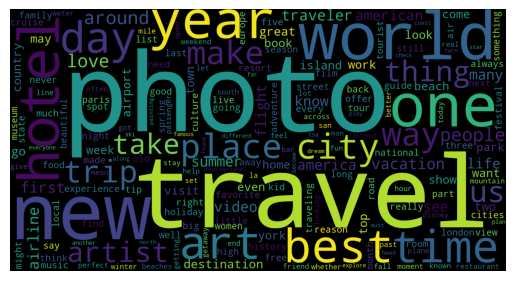

In [145]:
clean_travel_and_arts=clean_df[clean_df["new_category"] == "TRAVEL AND ARTS"]
text_travel_and_arts = " ".join(clean_all_words for clean_all_words in clean_travel_and_arts.clean_all_words)
word_cloud_travel_and_arts = WordCloud(collocations = False, background_color = 'black',
                        width = 2048, height = 1080).generate(text_travel_and_arts)
# saving the image
word_cloud_travel_and_arts.to_file('travel_and_arts_wordCloud.png')
plt.imshow(word_cloud_travel_and_arts)
plt.axis("off")
plt.show()

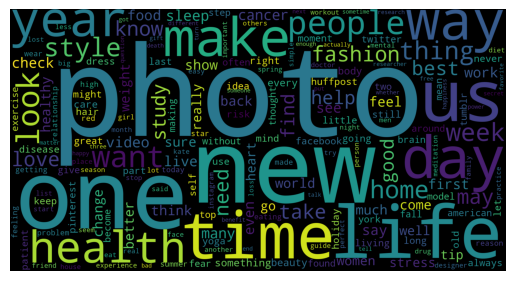

In [146]:
clean_lifestyle=clean_df[clean_df["new_category"] == "LIFESTYLE"]
text_lifestyle = " ".join(clean_all_words for clean_all_words in clean_lifestyle.clean_all_words)
word_cloud_lifestyle = WordCloud(collocations = False, background_color = 'black',
                        width = 2048, height = 1080).generate(text_lifestyle)
# saving the image
word_cloud_lifestyle.to_file('Lifestyle_wordCloud.png')
plt.imshow(word_cloud_lifestyle)
plt.axis("off")
plt.show()

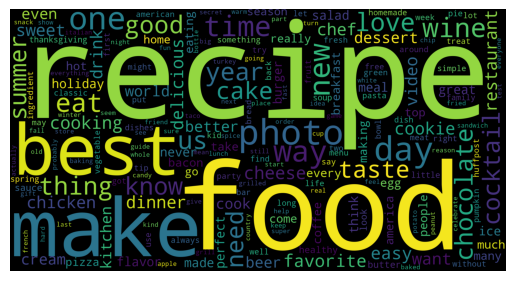

In [147]:
clean_food=clean_df[clean_df["new_category"] == "FOOD"]
text_food = " ".join(clean_all_words for clean_all_words in clean_food.clean_all_words)
word_cloud_food = WordCloud(collocations = False, background_color = 'black',
                        width = 2048, height = 1080).generate(text_food)
# saving the image
word_cloud_food.to_file('Food_wordCloud.png')
plt.imshow(word_cloud_food)
plt.axis("off")
plt.show()

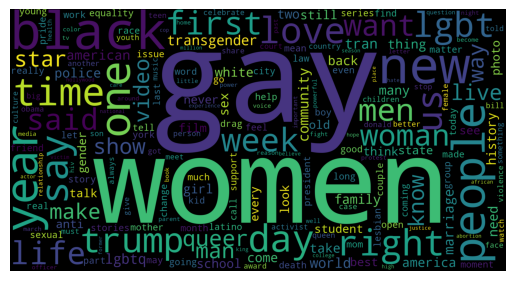

In [148]:
clean_diversity=clean_df[clean_df["new_category"] == "DIVERSITY"]
text_diversity = " ".join(clean_all_words for clean_all_words in clean_diversity.clean_all_words)
word_cloud_diversity = WordCloud(collocations = False, background_color = 'black',
                        width = 2048, height = 1080).generate(text_diversity)
# saving the image
word_cloud_diversity.to_file('Diversity_wordCloud.png')
plt.imshow(word_cloud_diversity)
plt.axis("off")
plt.show()

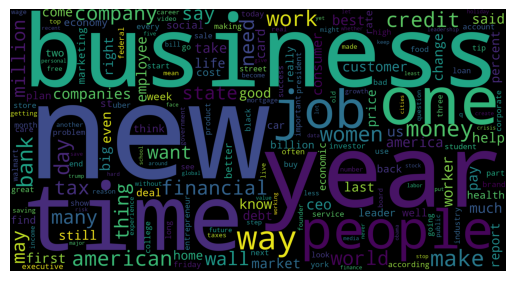

In [149]:
clean_business=clean_df[clean_df["new_category"] == "BUSINESS"]
text_business = " ".join(clean_all_words for clean_all_words in clean_business.clean_all_words)
word_cloud_business = WordCloud(collocations = False, background_color = 'black',
                        width = 2048, height = 1080).generate(text_business)
# saving the image
word_cloud_business.to_file('Business_wordCloud.png')
plt.imshow(word_cloud_business)
plt.axis("off")
plt.show()

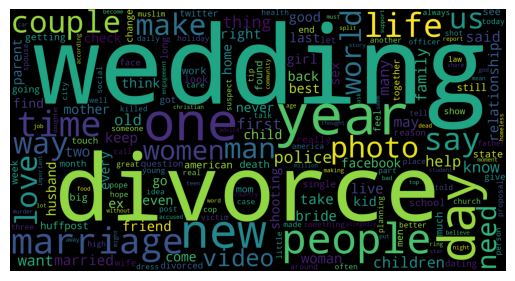

In [150]:
clean_miscellaneous=clean_df[clean_df["new_category"] == "MISCELLANEOUS"]
text_miscellaneous = " ".join(clean_all_words for clean_all_words in clean_miscellaneous.clean_all_words)
word_cloud_miscellaneous = WordCloud(collocations = False, background_color = 'black',
                        width = 2048, height = 1080).generate(text_miscellaneous)
# saving the image
word_cloud_miscellaneous.to_file('Miscellaneous_wordCloud.png')
plt.imshow(word_cloud_miscellaneous)
plt.axis("off")
plt.show()

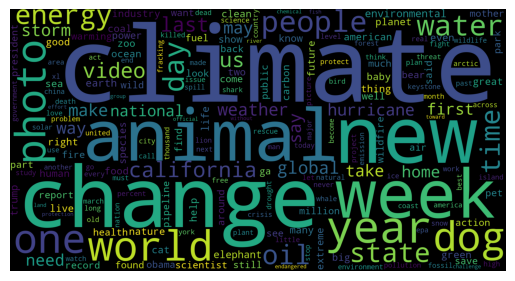

In [151]:
clean_environment=clean_df[clean_df["new_category"] == "ENVIRONMENT"]
text_environment = " ".join(clean_all_words for clean_all_words in clean_environment.clean_all_words)
word_cloud_environment = WordCloud(collocations = False, background_color = 'black',
                        width = 2048, height = 1080).generate(text_environment)
# saving the image
word_cloud_environment.to_file('Environment_wordCloud.png')
plt.imshow(word_cloud_environment)
plt.axis("off")
plt.show()

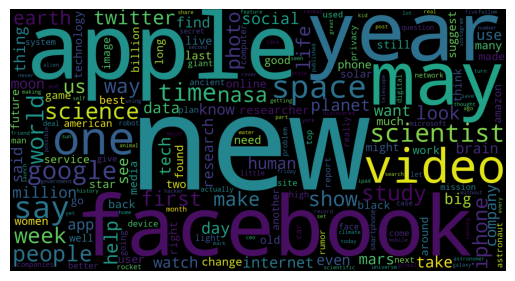

In [152]:
clean_technology=clean_df[clean_df["new_category"] == "TECHNOLOGY"]
text_technology = " ".join(clean_all_words for clean_all_words in clean_technology.clean_all_words)
word_cloud_technology = WordCloud(collocations = False, background_color = 'black',
                        width = 2048, height = 1080).generate(text_technology)
# saving the image
word_cloud_technology.to_file('Technology_wordCloud.png')
plt.imshow(word_cloud_technology)
plt.axis("off")
plt.show()

In [153]:
x_train,x_test, y_train,y_test = train_test_split(X,Y)

In [154]:
#MultinominalNB
from sklearn.naive_bayes import MultinomialNB

nb = Pipeline([ 
                ('vect', TfidfVectorizer()),
                ('clf', MultinomialNB()),
               ])
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)

print('accuracy %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=5))

accuracy 0.5597588978185993
              precision    recall  f1-score   support

           0    0.86667   0.02652   0.05146      1961
           1    0.84780   0.15545   0.26273      3834
           2    0.62740   0.72632   0.67324      7706
           3    0.66667   0.00402   0.00800       994
           4    0.91775   0.30387   0.45657      2093
           5    0.46178   0.93246   0.61767     10379
           6    0.77976   0.27485   0.40644      4457
           7    0.82828   0.24748   0.38110      2982
           8    0.81975   0.17835   0.29296      3723
           9    0.54788   0.92836   0.68909      9632
          10    0.93333   0.01344   0.02649      1042
          11    0.84439   0.32022   0.46435      3457

    accuracy                        0.55976     52260
   macro avg    0.76179   0.34261   0.36084     52260
weighted avg    0.67599   0.55976   0.49712     52260



In [155]:
# #Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', TfidfVectorizer()),
                 ('clf', LogisticRegression(n_jobs=1, C=1e5)),
                ])
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
print('accuracy %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=5))

accuracy 0.6906812093379258
              precision    recall  f1-score   support

           0    0.58567   0.52116   0.55154      1961
           1    0.58950   0.52139   0.55336      3834
           2    0.68874   0.73709   0.71209      7706
           3    0.51368   0.49095   0.50206       994
           4    0.76611   0.74964   0.75779      2093
           5    0.74189   0.80673   0.77295     10379
           6    0.59851   0.57864   0.58841      4457
           7    0.61510   0.55466   0.58332      2982
           8    0.67125   0.64222   0.65642      3723
           9    0.75624   0.78623   0.77095      9632
          10    0.60253   0.41171   0.48917      1042
          11    0.70699   0.67631   0.69131      3457

    accuracy                        0.69068     52260
   macro avg    0.65302   0.62306   0.63578     52260
weighted avg    0.68670   0.69068   0.68751     52260



In [156]:
# SGDClassifier
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', TfidfVectorizer()),
                 ('clf',  SGDClassifier(loss='hinge', penalty='l2')),
                ])
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_test)

print('accuracy %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=5))

accuracy 0.6692499043245312
              precision    recall  f1-score   support

           0    0.66091   0.33197   0.44196      1961
           1    0.69455   0.38550   0.49581      3834
           2    0.66687   0.71256   0.68896      7706
           3    0.57713   0.21831   0.31679       994
           4    0.73173   0.72719   0.72945      2093
           5    0.64598   0.86463   0.73948     10379
           6    0.69775   0.45165   0.54835      4457
           7    0.64042   0.48558   0.55236      2982
           8    0.63445   0.65404   0.64409      3723
           9    0.68982   0.86815   0.76878      9632
          10    0.67805   0.26679   0.38292      1042
          11    0.69072   0.60920   0.64740      3457

    accuracy                        0.66925     52260
   macro avg    0.66736   0.54796   0.57970     52260
weighted avg    0.67026   0.66925   0.65298     52260

